# Server

### Libraries

Install libraries

In [1]:
%cd "C:\Users\DELL\Documents\Python\AES"

C:\Users\DELL\Documents\Python\AES


In [2]:
# %pip install -r requirements.txt

Import libraries

In [3]:
import socket
import numpy as np
import cv2
from Crypto.Cipher import AES
import os
import glob
import time
from Crypto import Random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\Users\DELL\Documents\Python\venv\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll


### Server socket

In [4]:
HOST='192.168.137.1'
PORT=8000
WIDTH = 668
HEIGHT = 960
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.bind((HOST, PORT))
s.listen(2)

### Helps function:
- Receive data
- Generate 128/192/256 bit key from any key
- Make folder to save datas
- Socket connection
- Caputure an image from camera

In [5]:
def recv_all(sc, length):
    data = sc.recv(length)
    while True:
        miss_len_data = length - len(data)
        if miss_len_data==0:
            break
        data += sc.recv(miss_len_data)
    return data

def generateAESKey(key_string, len_key):
    '''Generate 128/192/256 bit key from any key'''
    key = bytes(key_string,"utf8")
    while len(key)<len_key:
        key = key + key
    return key[:len_key]

def make_folder(folder_name):
    path_f = os.path.abspath('')
    if os.path.isdir(path_f+"/"+folder_name) == False:
        os.mkdir(path_f+"/"+folder_name)
    list_folder = glob.glob(path_f+"/"+folder_name+"/*")
    max=0
    for i in list_folder:
        try:
            num = int(i.split("-")[1])
            if(max<num): max = num
        except: continue
    path = path_f+"/"+folder_name+"/data-"+str(max+1)
    os.mkdir(path)
    return path

# connect to client
def connect(s):
    print("Connecting...")
    try: 
        client, addr = s.accept()
        print('Connected by', addr)
        
    except:
        print("Run Client.py, Please")
    return client, addr

def takeImage(folder_save):
    print("Waiting for your camera...")
    vid = cv2.VideoCapture(0)
    # capture image 
    while True:
        rate,frame = vid.read() # read image from camera
        frame = cv2.resize(frame,(WIDTH,HEIGHT)) # resize image        
        
        if cv2.waitKey(1) & 0xFF == ord(' '): 
            # create folder
            
            cv2.imwrite(folder_save+"/The-original-image.bmp",frame) # save image
            cv2.destroyWindow("Camera")
            cv2.imshow("Capture",frame) # show image
            print("Took photos!")
            break
        frame = cv2.putText(frame, "Press 'space' to take a photo", (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)
        cv2.imshow("Capture",frame) # show image
    cv2.destroyAllWindows()
    return frame


    

### AES encryption and decryption

In [6]:
LENGTH_IV = AES.block_size
def encode_AES(data, key, mode):
    if mode != AES.MODE_ECB:
        IV = Random.new().read(LENGTH_IV)
        cipher = AES.new(key, mode, IV)
        ciphertext =   IV + cipher.encrypt(data)
    else:
        cipher = AES.new(key, AES.MODE_ECB)
        ciphertext = cipher.encrypt(data)
    return ciphertext

def decode_AES(data_enc, key, mode): # decode AES
    if mode != AES.MODE_ECB:
        IV_rec = data_enc[:LENGTH_IV]
        cipher = AES.new(key, mode, IV_rec)
        plaintext = cipher.decrypt(data_enc[LENGTH_IV:])
    else:
        cipher = AES.new(key, AES.MODE_ECB)
        plaintext = cipher.decrypt(data_enc)
    return plaintext

### Function that send an image to the client

In [7]:
def sendImage(client, image, key_AES, mode, save_path):
    print("Waiting for Client... ")
    
    # encode image
    st_time = time.time()
    im_byte = np.array(image).tobytes() # image -> bytes
    data_enc = encode_AES(im_byte, key_AES, mode) # encode AES
    enc_time = time.time()
    print(" - Encoded AES-%d (%.3f seconds)" %(8*len(key_AES),enc_time-st_time))

    # Send data
    print(" - Sending data to client...")
    client.send(data_enc) # send encoded data 
    recv_all(client,4) # wait server response
    print("   Client has received data! " )

    f_data_enc = open(save_path+"/Data-sent-to-client.enc", "wb")
    f_data_enc.write(data_enc)
    f_data_enc.close()

    # Show image encoded
    if mode ==AES.MODE_ECB:
        data_enc = np.frombuffer(data_enc, dtype = np.uint8)   #encoded data -> array
    else:
        data_enc = np.frombuffer(data_enc[LENGTH_IV:], dtype = np.uint8)
    data_enc = data_enc.reshape(HEIGHT, WIDTH, 3) # array encoded-> encoded image 

    cv2.imshow("Image encoded",data_enc) # show encoded image
    cv2.imwrite(save_path+"/AES-encrypted-image.bmp", data_enc)
    cv2.waitKey(0)
    print("Done!")

# def sendText(client, text, key_AES, mode, save_path):

#     print("Waiting for Client... ")
    
#     # encode image
#     st_time = time.time()
#     te_byte = np.array(text).tobytes() # image -> bytes
#     data_enc = encode_AES(te_byte, key_AES, mode) # encode AES
#     enc_time = time.time()
#     # with open(save_path,'rb') as f:
#     #     client.send(f.read())
#     #     f.close()
    
#     print(" - Encoded AES-%d (%.3f seconds)" %(8*len(key_AES),enc_time-st_time))

#     # Send data
#     print(" - Sending data to client...")
#     client.send(data_enc) # send encoded data 
#     recv_all(client,4) # wait server response
#     print("   Client has received data! " )
    
#     f_data_enc = open(save_path+"/Data-sent-to-client.enc", "wb")
#     f_data_enc.write(data_enc)
#     f_data_enc.close()

    


    # cv2.imshow("File  encoded",data_enc) # show encoded image
    # cv2.imwrite(save_path+"/AES-encrypted-image.bmp", data_enc)
    # cv2.waitKey(0)
#     print("Done!")

### Main function

- **Enter key**

In [8]:
key = "Nhom-17"

key_AES = generateAESKey(key, 16) # create AES key (128bit)
print("Your AES key: ", key_AES)

Your AES key:  b'Nhom-17Nhom-17Nh'


- **Make a connection to the client**

In [9]:
client, addr = connect(s) 

Connecting...
Connected by ('192.168.137.181', 49625)


- **Take an image from camera**

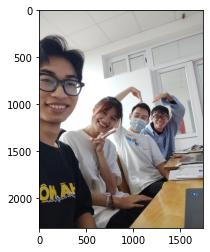

In [10]:
save_path = make_folder("Server_images") # make folder to save image
# image = takeImage(save_path)    # take image from camera
path = r"C:\Users\DELL\Pictures\Saved Pictures\Team17.jpg"
img = mpimg.imread(path)
plt.imshow(img)


In [11]:
image = cv2.imread(path)
image = cv2.resize(image,(WIDTH,HEIGHT))


#### Transmit the image with ECB mode

In [12]:
sendImage(client, image, key_AES, AES.MODE_ECB, save_path)

Waiting for Client... 
 - Encoded AES-128 (0.004 seconds)
 - Sending data to client...
   Client has received data! 
Done!


#### Transmit the image with CBC mode

In [13]:
sendImage(client, image, key_AES, AES.MODE_CBC, save_path)

Waiting for Client... 
 - Encoded AES-128 (0.007 seconds)
 - Sending data to client...
   Client has received data! 
Done!


In [14]:
# text = input()
# sendText(client,text,key_AES,AES.MODE_ECB,save_path)

In [15]:
client.close()